# Resolución del Problema de Programación de Horarios (con DEAP)

NSP – *Nurse Scheduling Problem*

Basado en: *Hands-On Genetic Algorithms with Python - Eyal Wirsansky*


## Problema

Se necesitan programar los turnos de las enfermeras de un hospital para la semana en curso. Existen tres turnos en un día (mañana, tarde y noche) y, para cada turno, se debe asignar una o más de las ocho enfermeras que trabajan. Además, el hospital presenta las siguientes reglas:
*	Una enfermera no puede trabajar dos turnos consecutivos.
*	Una enfermera no puede trabajar más de cinco turnos por semana.
*	El número de enfermeras por turno debe estar dentro de los siguientes límites:


> *	Turno de mañana: 2–3 enfermeras
> *	Turno de tarde: 2–4 enfermeras
> *	Turno de noche: 1–2 enfermeras

*   Además, cada enfermera puede tener preferencias de turno. Por ejemplo, una enfermera prefiere trabajar solo en turnos de mañana, otra enfermera prefiere no trabajar en turnos de tarde, y así sucesivamente.

**Contexto y cuestiones a considerar:**

Variaciones más complejas del problema, pueden incluir diferentes especialidades para diferentes enfermeras, la capacidad de trabajar en turnos de cobertura (horas extra) o incluso diferentes tipos de turnos, como turnos de 8 horas y turnos de 12 horas. Claramente, se tiene un problema acotado por varias restricciones, y, dentro de estas restricciones, no todas poseen las mismas características o rigidez.

Algunas de las restricciones mencionadas corresponden a reglas del hospital, por lo tanto, son **restricciones estrictas**, no pueden sobrepasarse. Un programa de horarios con alguna violación a estas restricciones se considera inválido. Por otra parte, las preferencias de las enfermeras se consideran **restricciones blandas**. Se buscan soluciones que prioricen las preferencias de la mayoría, pero una violación a alguna de ellas no invalida la solución.


## Enfoques posibles

Algunos enfoques para solucionar problemas de este estilo y sus limitaciones:

*	**Representación que elimina la posibilidad de una violación estricta**: la complejidad del problema puede variar considerablemente de acuerdo a la manera de codificar la solución, pero, muchas veces una codificación con estas características es difícil de encontrar.
*	**Descartar soluciones candidatas que violen alguna restricción estricta**: la desventaja de este enfoque es la pérdida de información contenida en estas soluciones, que puede ser valiosa para el problema. Esto podría ralentizar considerablemente el proceso de optimización.
*	**Reparar soluciones candidatas que violen alguna restricción estricta**: consiste en encontrar una manera de manipular la solución y/o modificarla para que no infrinja las restricciones. La creación de un procedimiento de reparación de este tipo puede resultar difícil o imposible para la mayoría de los problemas y, al mismo tiempo, el proceso de reparación puede provocar una pérdida significativa de información.
*	**Penalizar soluciones candidatas que violen alguna restricción estricta**: esto degradará la puntuación de la solución y la hará menos deseable, pero no la eliminará por completo, por lo que no se perderá la información que contiene. Efectivamente, esto lleva a que una restricción estricta se considere similar a una restricción blanda, pero con una penalización más severa. Al usar este método, el desafío puede ser encontrar la extensión apropiada de la pena. Una sanción demasiado severa puede llevar a la eliminación de facto de tales soluciones, mientras que una sanción demasiado pequeña puede hacer que estas soluciones parezcan óptimas.


En este *Notebook*, podrá encontrar una implementación según este último enfoque. Dicha penalización se suele implementar dentro de la función de costo, modificando la severidad según el tipo de restricción. Finalmente, el problema recae sobre uno del tipo “optimización”, en donde se busca minimizar esta función de costo.

## Generalidades respecto a la representación de la Solución

Para resolver el problema de la programación de enfermeras, se opta por usar una lista booleana para representar la programación del horario, ya que resulta en una interpretación intuitiva de los resultados.

Para cada enfermera, se puede tener una lista que representa los 21 turnos de la semana. Un valor de 1 representa un turno en el que la enfermera está programada para trabajar. Por ejemplo:

    [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]

Esto se puede dividir en los siguientes grupos de tres valores, que representan los turnos que esta enfermera trabajará cada día de la semana:

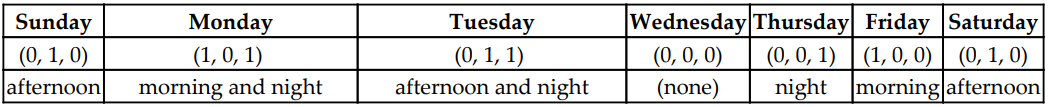


Los horarios de todas las enfermeras se pueden concatenar para crear una lista booleana mayor (matriz/arreglo), que represente la solución completa.
Al evaluar una solución, esta lista se puede desglosar en los horarios de las enfermeras individuales y se pueden verificar las violaciones de las restricciones.

El horario de la imagen, por ejemplo, contiene dos ocurrencias de valores 1 consecutivos que representan turnos consecutivos que deberá trabajar (tarde seguida de noche y noche seguida de mañana). El número de turnos semanales para esa misma enfermera se puede calcular sumando los valores booleanos de la lista, lo que da como resultado 8 turnos. También podemos comprobar fácilmente el cumplimiento de las preferencias de turno comparando los turnos de cada día con los turnos preferidos de esa enfermera.

Finalmente, para verificar las restricciones del número de enfermeras por turno, podemos sumar los horarios semanales de todas las enfermeras y buscar entradas que sean mayores que el máximo permitido o menores que el mínimo permitido.


## Instalaciones y Dependencias Necesarias

In [1]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

## Clase gestora del problema y sus restricciones

En la inicialización de esta clase, se definen los parámetros correspondientes a cada una de las restricciones.

In [3]:
class NurseSchedulingProblem:
    """
    This class encapsulates the Nurse Scheduling problem
    """

    def __init__(self, hardConstraintPenalty):
        """
        :param hardConstraintPenalty: the penalty factor for a hard-constraint violation
        """
        self.hardConstraintPenalty = hardConstraintPenalty

        # lista de enfermeras:
        self.nurses = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

        # preferencias de turno de las enfermeras - mañana, tarde, noche
        self.shiftPreference = [[1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 0], [0, 0, 1], [1, 1, 1], [0, 1, 1], [1, 1, 1]]

        # número mínimo y máximo de enfermeras permitidas para cada turno: mañana, tarde, noche
        self.shiftMin = [2, 2, 1]
        self.shiftMax = [3, 4, 2]

        # turnos máximos por semana permitidos para cada enfermera
        self.maxShiftsPerWeek = 5

        # número de semanas para la creación del horario
        self.weeks = 1

        # valores útiles (conversiones y demás)
        self.shiftPerDay = len(self.shiftMin)
        self.shiftsPerWeek = 7 * self.shiftPerDay

    def __len__(self):
        """
        :return: the number of shifts in the schedule
        """
        return len(self.nurses) * self.shiftsPerWeek * self.weeks


    def getCost(self, schedule):
        """
        Calculates the total cost of the various violations in the given schedule
        ...
        :param schedule: a list of binary values describing the given schedule
        :return: the calculated cost
        """

        if len(schedule) != self.__len__():
            raise ValueError("size of schedule list should be equal to ", self.__len__())

        # convert entire schedule into a dictionary with a separate schedule for each nurse:
        nurseShiftsDict = self.getNurseShifts(schedule)

        # count the various violations:
        consecutiveShiftViolations = self.countConsecutiveShiftViolations(nurseShiftsDict)
        shiftsPerWeekViolations = self.countShiftsPerWeekViolations(nurseShiftsDict)[1]
        nursesPerShiftViolations = self.countNursesPerShiftViolations(nurseShiftsDict)[1]
        shiftPreferenceViolations = self.countShiftPreferenceViolations(nurseShiftsDict)

        # calculate the cost of the violations:
        hardContstraintViolations = consecutiveShiftViolations + nursesPerShiftViolations + shiftsPerWeekViolations
        softContstraintViolations = shiftPreferenceViolations

        return self.hardConstraintPenalty * hardContstraintViolations + softContstraintViolations

    def getNurseShifts(self, schedule):
        """
        Converts the entire schedule into a dictionary with a separate schedule for each nurse
        :param schedule: a list of binary values describing the given schedule
        :return: a dictionary with each nurse as a key and the corresponding shifts as the value
        """
        shiftsPerNurse = self.__len__() // len(self.nurses)
        nurseShiftsDict = {}
        shiftIndex = 0

        for nurse in self.nurses:
            nurseShiftsDict[nurse] = schedule[shiftIndex:shiftIndex + shiftsPerNurse]
            shiftIndex += shiftsPerNurse

        return nurseShiftsDict

    def countConsecutiveShiftViolations(self, nurseShiftsDict):
        """
        Counts the consecutive shift violations in the schedule
        :param nurseShiftsDict: a dictionary with a separate schedule for each nurse
        :return: count of violations found
        """
        violations = 0
        # iterate over the shifts of each nurse:
        for nurseShifts in nurseShiftsDict.values():
            # look for two cosecutive '1's:
            for shift1, shift2 in zip(nurseShifts, nurseShifts[1:]):
                if shift1 == 1 and shift2 == 1:
                    violations += 1
        return violations

    def countShiftsPerWeekViolations(self, nurseShiftsDict):
        """
        Counts the max-shifts-per-week violations in the schedule
        :param nurseShiftsDict: a dictionary with a separate schedule for each nurse
        :return: count of violations found
        """
        violations = 0
        weeklyShiftsList = []
        # iterate over the shifts of each nurse:
        for nurseShifts in nurseShiftsDict.values():  # all shifts of a single nurse
            # iterate over the shifts of each weeks:
            for i in range(0, self.weeks * self.shiftsPerWeek, self.shiftsPerWeek):
                # count all the '1's over the week:
                weeklyShifts = sum(nurseShifts[i:i + self.shiftsPerWeek])
                weeklyShiftsList.append(weeklyShifts)
                if weeklyShifts > self.maxShiftsPerWeek:
                    violations += weeklyShifts - self.maxShiftsPerWeek

        return weeklyShiftsList, violations

    def countNursesPerShiftViolations(self, nurseShiftsDict):
        """
        Counts the number-of-nurses-per-shift violations in the schedule
        :param nurseShiftsDict: a dictionary with a separate schedule for each nurse
        :return: count of violations found
        """
        # sum the shifts over all nurses:
        totalPerShiftList = [sum(shift) for shift in zip(*nurseShiftsDict.values())]

        violations = 0
        # iterate over all shifts and count violations:
        for shiftIndex, numOfNurses in enumerate(totalPerShiftList):
            dailyShiftIndex = shiftIndex % self.shiftPerDay  # -> 0, 1, or 2 for the 3 shifts per day
            if (numOfNurses > self.shiftMax[dailyShiftIndex]):
                violations += numOfNurses - self.shiftMax[dailyShiftIndex]
            elif (numOfNurses < self.shiftMin[dailyShiftIndex]):
                violations += self.shiftMin[dailyShiftIndex] - numOfNurses

        return totalPerShiftList, violations

    def countShiftPreferenceViolations(self, nurseShiftsDict):
        """
        Counts the nurse-preferences violations in the schedule
        :param nurseShiftsDict: a dictionary with a separate schedule for each nurse
        :return: count of violations found
        """
        violations = 0
        for nurseIndex, shiftPreference in enumerate(self.shiftPreference):
            # duplicate the shift-preference over the days of the period
            preference = shiftPreference * (self.shiftsPerWeek // self.shiftPerDay)
            # iterate over the shifts and compare to preferences:
            shifts = nurseShiftsDict[self.nurses[nurseIndex]]
            for pref, shift in zip(preference, shifts):
                if pref == 0 and shift == 1:
                    violations += 1

        return violations

    def printScheduleInfo(self, schedule):
        """
        Imprime el cronograma y los detalles de las infracciones.
        :schedule: una lista de valores binarios que describen el horario dado
        """
        nurseShiftsDict = self.getNurseShifts(schedule)

        print("Horario para cada enfermera:")
        for nurse in nurseShiftsDict:  # all shifts of a single nurse
            print(nurse, ":", nurseShiftsDict[nurse])

        print("Violaciones (turnos consecutivos) =", self.countConsecutiveShiftViolations(nurseShiftsDict))
        print()

        weeklyShiftsList, violations = self.countShiftsPerWeekViolations(nurseShiftsDict)
        print("Turnos semanales = ", weeklyShiftsList)
        print("Violaciones (turnos por semana) = ", violations)
        print()

        totalPerShiftList, violations = self.countNursesPerShiftViolations(nurseShiftsDict)
        print("Enfermeras por Turno = ", totalPerShiftList)
        print("Violaciones (enfermeras por turno) = ", violations)
        print()

        shiftPreferenceViolations = self.countShiftPreferenceViolations(nurseShiftsDict)
        print("Violaciones 'blandas' (preferencias en los turnos) = ", shiftPreferenceViolations)
        print()

### Instancia de la clase y métricas relacionadas

In [4]:
# Instancia del problema:
PENALIZACION = 10
nurses = NurseSchedulingProblem(PENALIZACION)

# Evaluación de una solución aleatoria
randomSolution = np.random.randint(2, size=len(nurses))
print("Solución Aleatoria = ")
print(randomSolution)
print()

nurses.printScheduleInfo(randomSolution)

print("Costo Total de la Solución = ", nurses.getCost(randomSolution))

Solución Aleatoria = 
[1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0
 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0
 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0
 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1]

Horario para cada enfermera:
A : [1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1]
B : [0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1]
C : [0 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 0 0]
D : [1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0]
E : [0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1]
F : [0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0]
G : [1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0]
H : [0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1]
Violaciones (turnos consecutivos) = 41

Turnos semanales =  [13, 10, 10, 12, 13, 12, 7, 12]
Violaciones (turnos por semana) =  49

Enfermeras por Turno =  [3, 4, 8, 2, 5, 2, 4, 5, 6, 3, 4, 5, 3, 5, 6, 2, 8, 4, 2, 4, 4]
Vio

Como es evidente a partir de estos resultados, es probable que una solución generada aleatoriamente produzca una gran cantidad de infracciones y, en consecuencia, un gran valor de costo.

## Función para la evaluación del Algoritmos

In [5]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
                        halloffame=None, verbose=__debug__):
    """
     Este algoritmo es similar al algoritmo DEAP eaSimple(), con la modificación de que
     halloffame se utiliza para implementar un mecanismo de elitismo. Los individuos contenidos en el
     halloffame se inyectan directamente en la próxima generación y no están sujetos a los
     Operadores genéticos de selección, cruce y mutación.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Se evalúan los individuos con una aptitud inválida
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Comienza el proceso generacional
    for gen in range(1, ngen + 1):

        # Selección de los individuos para la próxima generación
        offspring = toolbox.select(population, len(population) - hof_size)

        # Variación del grupo de individuos
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluación de los individuos con una aptitud inválida
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # El mejor se agreaga al "Salón de la Fama"
        offspring.extend(halloffame.items)

        # Se actualiza el salón de la fama con los individuos generados
        halloffame.update(offspring)

        # Se reemplaza la población actual por la descendencia
        population[:] = offspring

        # Se agrega las estadísticas de la generación actual a los registros
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

## Constantes e Hiper parámetros

In [6]:
# Constantes del problemas:
HARD_CONSTRAINT_PENALTY = 10  # Factor de penalización para una violación del tipo: restricción dura

# Constantes del algoritmo genético:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9           # Probabilidad para crossover
P_MUTATION = 0.1            # Probabilidad de mutar a un individuo
MAX_GENERATIONS = 200       # Criterio de parada, número máximo de generaciones a evaluar
HALL_OF_FAME_SIZE = 30      # Tamaño del Salón de la Fama

## Función para obtener el Fitness

In [7]:
def getCost(individual):
    return nsp.getCost(individual),  # Devuelve una tupla (',' al final)

## Instancias para el problema

In [8]:
# Semilla para repetibilidad de los pseudoaleatorios
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

# Instancia del problema
nsp = NurseSchedulingProblem(HARD_CONSTRAINT_PENALTY)

# Se define un único objetivo, minimizar la métrica de fitness:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Los pesos definen si se Maximiza (1) o Minimiza (-1) en la Optimización

# Se crea la clase individuo basada en la lista, con la característica a evaluar
creator.create("Individual", list, fitness=creator.FitnessMin)

# Se crea un operador que devuelva aleatoriamente 0 o 1
toolbox.register("zeroOrOne", random.randint, 0, 1)

# Se crean la instancia que indica como se crean los individuos
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(nsp))

# Se crea el operador de población para generar una lista de individuos
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

toolbox.register("evaluate", getCost)

# Operadores genéticos:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(nsp))


## Obtención de soluciones

In [9]:
# Se crea la población inicial (generación 0)
population = toolbox.populationCreator(n=POPULATION_SIZE)

# Se define la instancia para almacenar estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Se define el salón de la fama
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# Comienza toda la magia, una vez configurado los parámetros
population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                            ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)



gen	nevals	min	avg    
0  	300   	689	1158.77
1  	245   	689	1028.02
2  	239   	538	909.587
3  	229   	489	803.7  
4  	247   	445	729.993
5  	239   	342	667.38 
6  	250   	342	597.19 
7  	252   	272	532.763
8  	249   	264	465.397
9  	250   	224	411.48 
10 	245   	217	357.667
11 	255   	134	317.667
12 	246   	134	280.203
13 	237   	103	251.517
14 	248   	103	229.01 
15 	249   	103	203.493
16 	248   	103	183.67 
17 	248   	95 	169.177
18 	240   	86 	152.1  
19 	240   	74 	139.787
20 	246   	73 	121.847
21 	242   	63 	109.88 
22 	245   	63 	103.863
23 	239   	52 	98.3333
24 	238   	52 	91.6767
25 	248   	31 	85.5867
26 	245   	31 	78.7767
27 	248   	31 	73.26  
28 	241   	31 	70.0667
29 	233   	31 	64.95  
30 	242   	31 	60.83  
31 	257   	30 	57.6833
32 	247   	29 	52.62  
33 	248   	21 	48.8367
34 	241   	19 	46.5733
35 	247   	16 	43.5   
36 	251   	14 	41.1533
37 	249   	14 	38.84  
38 	252   	13 	35.44  
39 	253   	13 	33.3367
40 	255   	13 	32.13  
41 	254   	12 	31.07  
42 	243   	

--Mejor Individuo =  [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
-- Mejor Desempeño =  3.0

-- Horario/Cronograma Resultante = 
Horario para cada enfermera:
A : [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
B : [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
C : [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]
D : [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
E : [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
F : [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1

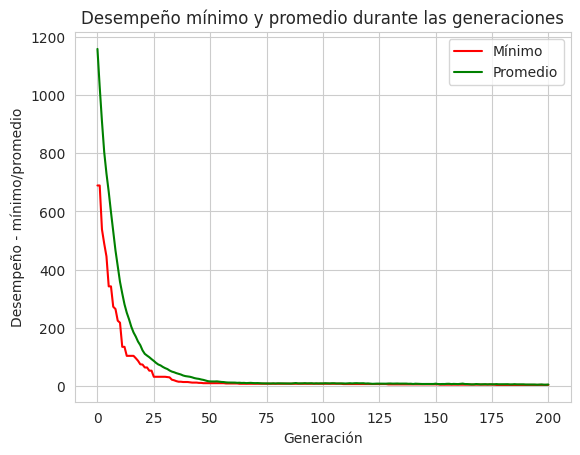

In [10]:
# Mejor solución encontrada
best = hof.items[0]
print("--Mejor Individuo = ", best)
print("-- Mejor Desempeño = ", best.fitness.values[0])
print()
print("-- Horario/Cronograma Resultante = ")
nsp.printScheduleInfo(best)

# Estadística para gráfica:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

# Gráfica:
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generación')
plt.ylabel('Desempeño - mínimo/promedio')
plt.title('Desempeño mínimo y promedio durante las generaciones')
plt.legend(['Mínimo', 'Promedio'])
plt.show()